## Fruits recognition

### Import all the Dependencies

In [38]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

#### Set constant

In [39]:
BATCH_SIZE = 32
IMAGE_SIZE = 300
CHANNELS=3
EPOCHS=40

#### Import fruits data into tensorflow dataset object

In [40]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1212 files belonging to 6 classes.


In [41]:
class_names = dataset.class_names
class_names

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

In [42]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 300, 300, 3)
[3 3 0 1 5 0 3 4 3 5 4 5 5 0 1 3 1 1 1 4 0 1 5 2 2 2 4 1 1 3 0 5]


Each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

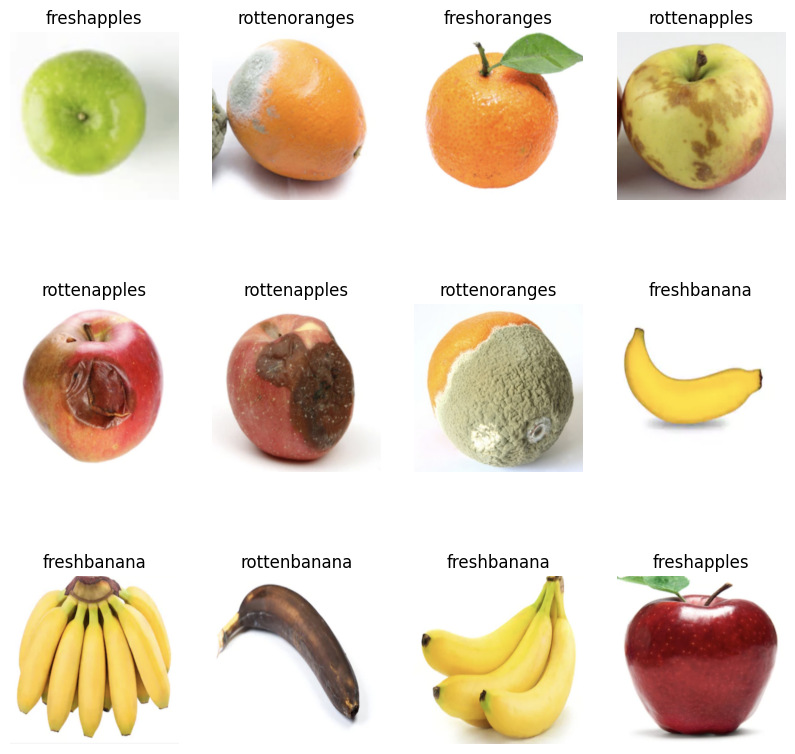

In [43]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:
<br>
**Training**: Dataset to be used while training <br>
**Validation**: Dataset to be tested against while training<br>
**Test**: Dataset to be tested against after we trained a model<br>

In [44]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [45]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [46]:
len(train_ds)

30

In [47]:
len(val_ds)

3

In [48]:
len(test_ds)

5

### Cache, Shuffle, and Prefetch the Dataset

In [49]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

#### Creating a Layer for Resizing and Normalization

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [50]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#### Data Augmentation


Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
It rorate the image in posssible way and that are used for model training.

In [51]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [52]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [53]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 300, 300, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 298, 298, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 149, 149, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 147, 147, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 73, 73, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 71, 71, 64)         

#### Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [55]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [56]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=40,   
)

Epoch 1/40
30/30 [==============================] - 98s 3s/step - loss: 1.6547 - accuracy: 0.3201 - val_loss: 1.3867 - val_accuracy: 0.3750
Epoch 2/40
30/30 [==============================] - 76s 2s/step - loss: 1.3547 - accuracy: 0.4519 - val_loss: 1.2407 - val_accuracy: 0.4583
Epoch 3/40
30/30 [==============================] - 72s 2s/step - loss: 1.2135 - accuracy: 0.5000 - val_loss: 1.2781 - val_accuracy: 0.4167
Epoch 4/40
30/30 [==============================] - 75s 2s/step - loss: 1.0882 - accuracy: 0.5680 - val_loss: 0.9516 - val_accuracy: 0.5729
Epoch 5/40
30/30 [==============================] - 74s 2s/step - loss: 0.9438 - accuracy: 0.6182 - val_loss: 0.7843 - val_accuracy: 0.6875
Epoch 6/40
30/30 [==============================] - 71s 2s/step - loss: 0.8756 - accuracy: 0.6475 - val_loss: 0.8209 - val_accuracy: 0.6771
Epoch 7/40
30/30 [==============================] - 70s 2s/step - loss: 0.8000 - accuracy: 0.7082 - val_loss: 0.6744 - val_accuracy: 0.7396
Epoch 8/40
30/30 [==

5/5 [==============================] - 8s 597ms/step - loss: 0.2515 - accuracy: 0.8875
Accuracy: 88.75%


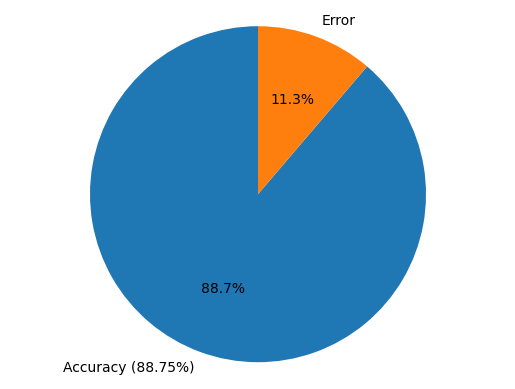

In [57]:
import matplotlib.pyplot as plt

# Evaluate the model on the test dataset and extract the accuracy
scores = model.evaluate(test_ds)
accuracy = scores[1]

# Print the accuracy as text
print(f"Accuracy: {accuracy * 100:.2f}%")

# Create a pie chart to visualize the accuracy
fig, ax = plt.subplots()
ax.pie([accuracy, 1 - accuracy], labels=[f"Accuracy ({accuracy * 100:.2f}%)", "Error"], autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()


EXISTING SYSTEM ACCURANCY 

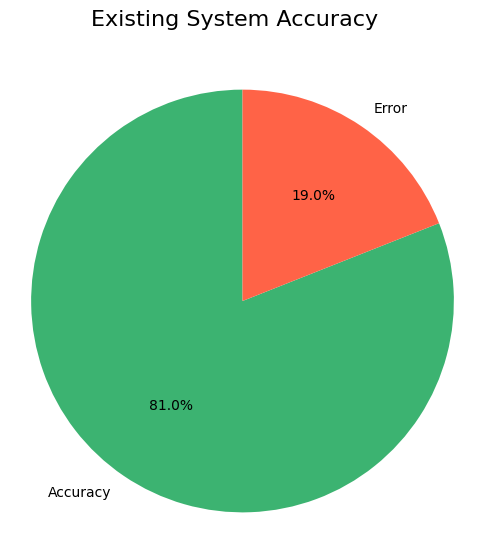

In [58]:
import matplotlib.pyplot as plt

# Accuracy value (81%)
accuracy = 0.81

# Create a figure with a pie chart
plt.figure(figsize=(6, 6))

# Set the title for the entire figure
plt.suptitle('Existing System Accuracy', fontsize=16)

# Create a pie chart
labels = ['Accuracy', 'Error']
sizes = [accuracy, 1 - accuracy]
colors = ['#3CB371', '#FF6347']  # Green and Red colors
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the pie chart
plt.show()


You can see above that we get 90.62% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [59]:
scores

[0.2514539062976837, 0.887499988079071]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [60]:
history

In [61]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 30}

In [62]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [63]:
type(history.history['loss'])

list

In [64]:
len(history.history['loss'])

40

In [65]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.6547285318374634,
 1.3546946048736572,
 1.2134671211242676,
 1.088229775428772,
 0.9438417553901672]

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

FOR EXISTING SYSTEM, WE GOT ACCURANCY 80.1%  AND BELOW ARE THEIR RESULTS ---- EXISTING SYSTEM

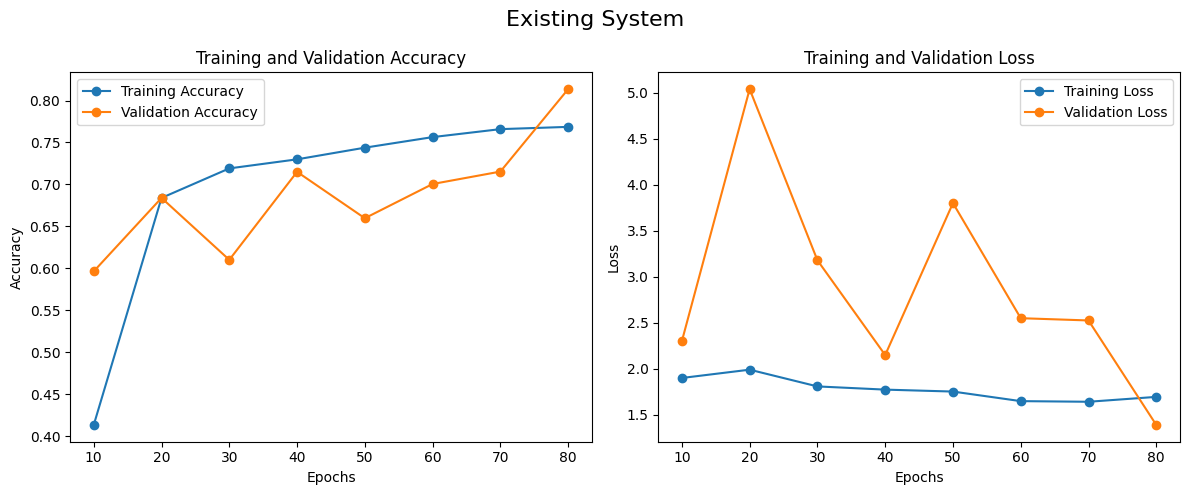

In [67]:
import matplotlib.pyplot as plt

# Given data
epochs = [10, 20, 30, 40, 50, 60, 70, 80]
accuracy = [0.4133, 0.6839, 0.7191, 0.7299, 0.7438, 0.7564, 0.7659, 0.7686]
loss = [1.9018, 1.9920, 1.8101, 1.7753, 1.7542, 1.6502, 1.6433, 1.6964]
val_accuracy = [0.5964, 0.6839, 0.6101, 0.7150, 0.6597, 0.7005, 0.7153, 0.8136]
val_loss = [2.3018, 5.0413, 3.1813, 2.1511, 3.8025, 2.5516, 2.5270, 1.3915]

# Create subplots for accuracy and loss
plt.figure(figsize=(12, 5))

# Set the main title for the entire figure
plt.suptitle('Existing System', fontsize=16)

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o', linestyle='-')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', linestyle='-')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', linestyle='-')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#### Run prediction on a sample image

1/1 [==============================] - 0s 43ms/step


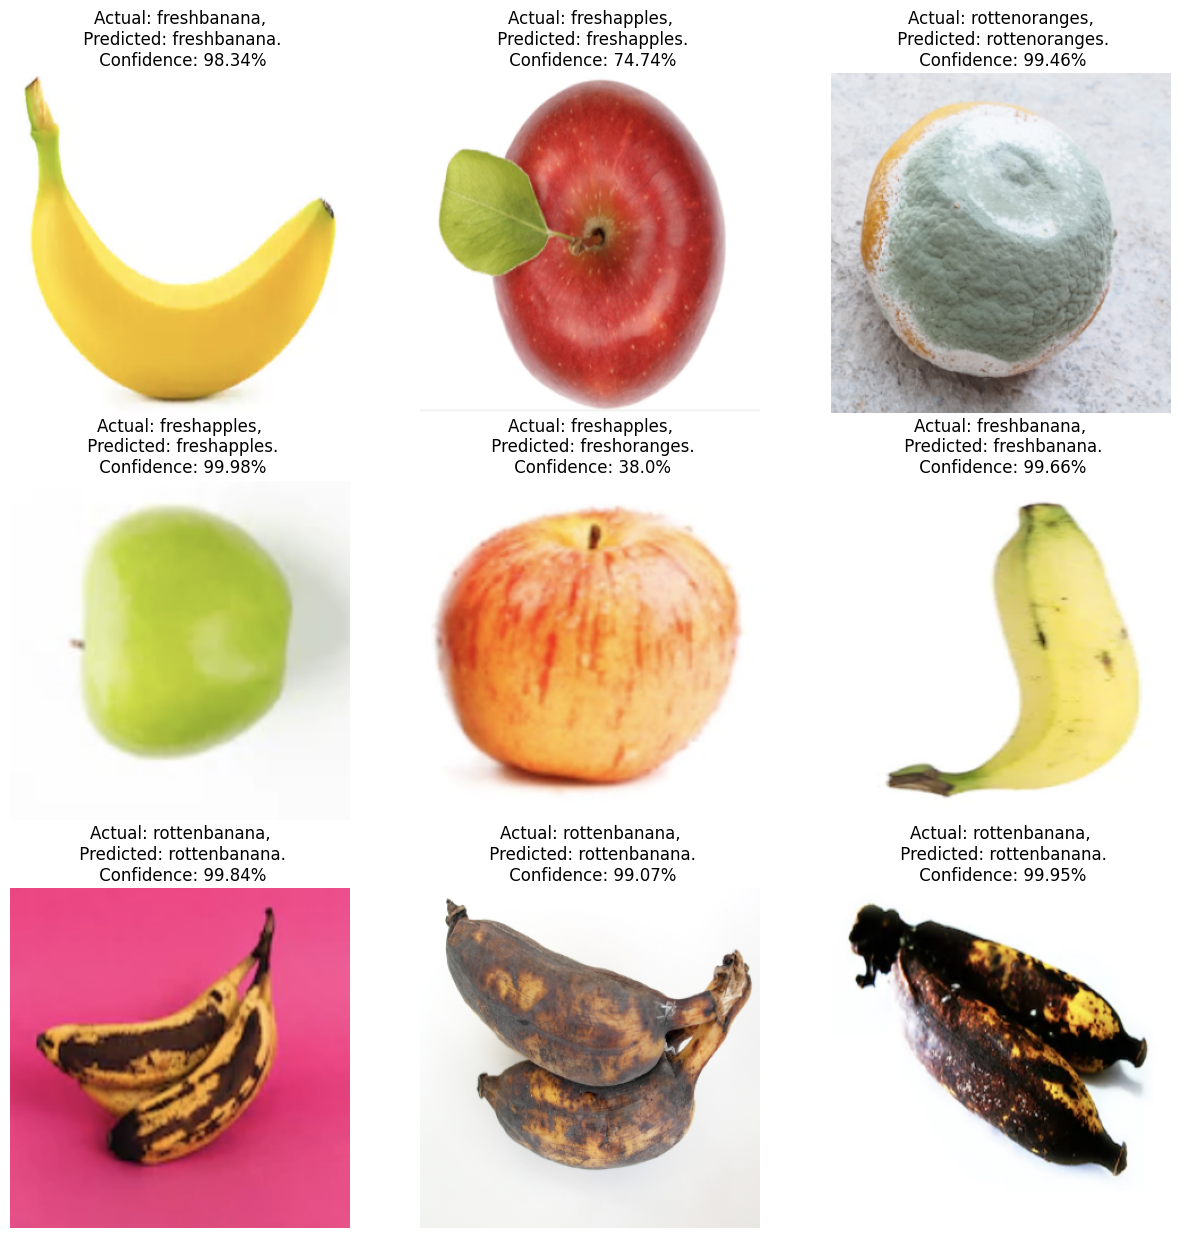

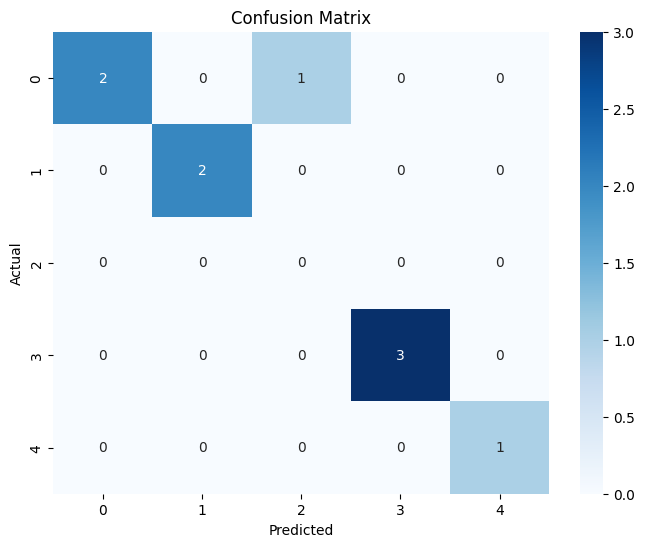

In [68]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Lists to store predicted and actual classes
predicted_classes = []
actual_classes = []

# Loop through the test dataset obtained from your partitioning function
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

        # Append the predicted and actual classes to the lists
        predicted_classes.append(predicted_class)
        actual_classes.append(actual_class)

# Create a confusion matrix
confusion_mat = confusion_matrix(actual_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


#### Write a function for inference

In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample imagesNow run inference on few sample images

#### Saving the Model

We append the model to the list of models as a new version

In [70]:
import os

# List all files in the "models" directory
model_files = [f for f in os.listdir("models") if f.isdigit()]

# If there are no model files, start with version 0
if not model_files:
    model_version = 0
else:
    # Convert the list of file names to integers and find the maximum
    model_version = max(map(int, model_files))

# Increment the model_version
model_version += 1

model.save(f"models/{model_version}")


INFO:tensorflow:Assets written to: models/3\assets


INFO:tensorflow:Assets written to: models/3\assets


In [71]:
model.save("models/fruits.h5")

c:\Users\Dhruva\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
